In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transform
import torchmetrics
import random
import matplotlib
import matplotlib.pyplot as matplot

from torchvision.datasets import ImageFolder, DatasetFolder
from torch.utils.data import DataLoader, Subset, random_split, ConcatDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, Normalize, Compose
from torchmetrics import F1Score, Accuracy
from PIL import Image

from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
project_name='rock-paper-scissors'

In [3]:
# Data directory
data_dir = './dataset'
print(os.listdir(data_dir))

# Classes
# Place all the images according to there class in 3 different folders (Rock, Paper, Scissors)
classes = os.listdir(data_dir)
print(classes)

['paper', 'rock', 'scissors']
['paper', 'rock', 'scissors']


In [4]:
stats=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# Transform for training dataset
train_transform = transform.Compose([
                         transform.Resize((32,32)), 
                         transform.RandomHorizontalFlip(), 
                         transform.ToTensor(), 
                         transform.Normalize(*stats,inplace=True)])

# Transform for validation dataset
valid_transform = transform.Compose([transform.Resize((32,32)),transform.ToTensor(), transform.Normalize(*stats)])

In [5]:
# Complete data (Includes images from four datasets)
rock_paper_scissors_data = ImageFolder(data_dir, train_transform)

In [6]:
# Diving the dataset in the ratio of 85% and 15%
# Training dataset - 85%
# Validation dataset - 15%
train_size = int(0.85 * len(rock_paper_scissors_data))
val_size = len(rock_paper_scissors_data) - train_size
train_dataset, val_dataset = random_split(rock_paper_scissors_data, [train_size, val_size])

In [7]:
# Batch Size
batch_size = 64

# Number of classes (3)
# Rock, Paper, Scissors
num_of_classes = len(classes)

In [8]:
# Custom validation dataset from university
# **Remove this or comment the code if you are not using any custom dataset**
custom_val_dataset = ImageFolder("./custom-dataset/validation", valid_transform)

# Merging the custom validation dataset with the validation dataset
complete_val_dataset = ConcatDataset([val_dataset,custom_val_dataset])

In [9]:
# Custom test dataset from university
# **Remove this or comment the code if you are not using any custom dataset**
test_dataset = ImageFolder("./custom-dataset/test", valid_transform)

In [10]:
# Dataloaders for train, test & validation
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dataloader = DataLoader(complete_val_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=3, pin_memory=True)

In [ ]:
# Function to show images
def show_images(dataloader):
    for images, labels in dataloader:
        fig, ax = matplot.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break


In [ ]:
show_images(val_dataloader)

In [11]:
# Function to get the device GPU or CPU
# Install Cuda if you want use GPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to move the data on to the device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Moving Dataloader on the device('Cuda' if available)
# train_dataloader = DeviceDataLoader(train_dataloader, device)
# val_dataloader = DeviceDataLoader(val_dataloader, device)

In [13]:
# Resnet9 model

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        
        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)
        out = self.classifier(out)

        return out

In [14]:
# k = Number of folds
k = 10
number_of_epochs = 50
learning_rate = 0.001
weight_decay = 1e-4

In [15]:
# F-1 Score
def get_f1score(preds, labels):
    f1_score = F1Score(task="multiclass", num_classes=num_of_classes, average='weighted')
    return f1_score(preds, labels)

In [16]:
# Accuracy
def get_accuracy(preds, labels):
    accuracy = Accuracy(task="multiclass", num_classes=num_of_classes).to(device)
    return accuracy(preds, labels)

In [17]:
# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

In [18]:
# Evaluate model
def evaluate(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    return all_preds, all_labels

In [ ]:
type(train_dataloader)

In [ ]:
# Without K-fold cross-validation
    
# Model
model = ResNet9()
model.to(device)
    
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
train_losses = []
train_accuracies = []
    
val_losses = []
val_accuracies = []
    
# Train and validate for this fold
for epoch in range(number_of_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    val_loss = train(model,val_dataloader,criterion,optimizer)
        
    # Loss
    train_losses.append(train_loss)
    val_losses.append(val_loss)
        
    preds, labels = evaluate(model, train_dataloader)
    train_accuracy = get_accuracy(preds, labels)

    preds, labels = evaluate(model, val_dataloader)
    val_accuracy = get_accuracy(preds, labels)

    # Accuracies
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
        
    print(f'Epoch {epoch + 1} - Train loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val loss: {val_loss:.4f} - Val accuracy: {val_accuracy:.4f}')
    
# Saving the Current Fold Model
torch.save(model, f'withoutKFold.pth')

In [19]:
# K-fold cross-validation
kf = KFold(n_splits=k, shuffle=True)

# Train and validate for each fold
for fold, (train_indices, val_indices) in enumerate(kf.split(rock_paper_scissors_data)):
    print(f'Fold {fold + 1}/{k}')
    
    # Create subset datasets and dataloaders for this fold
    train_subset = Subset(rock_paper_scissors_data, train_indices)
    val_subset = Subset(rock_paper_scissors_data, val_indices) + custom_val_dataset
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(kfold_val_subset, batch_size=64, shuffle=False)
    
    # Model
    model = ResNet9()
    model.to(device)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    train_losses = []
    train_accuracies = []
    
    val_losses = []
    val_accuracies = []
        
    # Train and validate for this fold
    for epoch in range(number_of_epochs):
        train_loss = train(model, train_loader, criterion, optimizer)
        val_loss = train(model,kfold_val_loader,criterion,optimizer)
        
        # Loss
        train_losses.append(train_loss)
        kfold_val_losses.append(kfold_val_loss)
        
        preds, labels = evaluate(model, train_loader)
        train_accuracy = get_accuracy(preds, labels)

        preds, labels = evaluate(model, kfold_val_loader)
        kfold_val_accuracy = get_accuracy(preds, labels)

        # Accuracies
        train_accuracies.append(train_accuracy)
        kfold_val_accuracies.append(kfold_val_accuracy)
#         val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch + 1} - Train loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Val loss: {kfold_val_loss:.4f} - Val accuracy: {kfold_val_accuracy:.4f}')
    
    # Saving the Current Fold Model
    torch.save(model, f'fold{fold}.pth')

Fold 1/10
Epoch 1 - Train loss: 0.5310 - Train Accuracy: 0.3346 - Val loss: 3.9598 - Val accuracy: 0.3429
Epoch 2 - Train loss: 1.0452 - Train Accuracy: 0.5092 - Val loss: 3.2125 - Val accuracy: 0.4794
Epoch 3 - Train loss: 0.7635 - Train Accuracy: 0.4726 - Val loss: 2.8105 - Val accuracy: 0.4644
Epoch 4 - Train loss: 0.5573 - Train Accuracy: 0.5757 - Val loss: 2.1652 - Val accuracy: 0.5539
Epoch 5 - Train loss: 0.3977 - Train Accuracy: 0.6361 - Val loss: 1.9375 - Val accuracy: 0.5986
Epoch 6 - Train loss: 0.3291 - Train Accuracy: 0.5885 - Val loss: 1.9213 - Val accuracy: 0.5550
Epoch 7 - Train loss: 0.2930 - Train Accuracy: 0.6627 - Val loss: 1.7846 - Val accuracy: 0.6204
Epoch 8 - Train loss: 0.2723 - Train Accuracy: 0.7846 - Val loss: 1.5643 - Val accuracy: 0.7259
Epoch 9 - Train loss: 0.2248 - Train Accuracy: 0.8848 - Val loss: 1.2256 - Val accuracy: 0.8085
Epoch 10 - Train loss: 0.2023 - Train Accuracy: 0.9183 - Val loss: 1.1180 - Val accuracy: 0.8555
Epoch 11 - Train loss: 0.1707

Epoch 36 - Train loss: 0.0034 - Train Accuracy: 0.9868 - Val loss: 0.0347 - Val accuracy: 0.9392
Epoch 37 - Train loss: 0.0020 - Train Accuracy: 0.9545 - Val loss: 0.0420 - Val accuracy: 0.9071
Epoch 38 - Train loss: 0.0051 - Train Accuracy: 0.9994 - Val loss: 0.0149 - Val accuracy: 0.9587
Epoch 39 - Train loss: 0.0016 - Train Accuracy: 1.0000 - Val loss: 0.0092 - Val accuracy: 0.9679
Epoch 40 - Train loss: 0.0006 - Train Accuracy: 0.9999 - Val loss: 0.0072 - Val accuracy: 0.9759
Epoch 41 - Train loss: 0.0008 - Train Accuracy: 1.0000 - Val loss: 0.0070 - Val accuracy: 0.9667
Epoch 42 - Train loss: 0.0008 - Train Accuracy: 0.9997 - Val loss: 0.0059 - Val accuracy: 0.9805
Epoch 43 - Train loss: 0.0004 - Train Accuracy: 0.9999 - Val loss: 0.0053 - Val accuracy: 0.9759
Epoch 44 - Train loss: 0.0012 - Train Accuracy: 1.0000 - Val loss: 0.0028 - Val accuracy: 0.9656
Epoch 45 - Train loss: 0.0007 - Train Accuracy: 0.9999 - Val loss: 0.0028 - Val accuracy: 0.9702
Epoch 46 - Train loss: 0.0004 

Epoch 21 - Train loss: 0.0280 - Train Accuracy: 0.9371 - Val loss: 0.1491 - Val accuracy: 0.8693
Epoch 22 - Train loss: 0.0233 - Train Accuracy: 0.9458 - Val loss: 0.1847 - Val accuracy: 0.9025
Epoch 23 - Train loss: 0.0197 - Train Accuracy: 0.9460 - Val loss: 0.1575 - Val accuracy: 0.8945
Epoch 24 - Train loss: 0.0173 - Train Accuracy: 0.9935 - Val loss: 0.1051 - Val accuracy: 0.9346
Epoch 25 - Train loss: 0.0139 - Train Accuracy: 0.9945 - Val loss: 0.1303 - Val accuracy: 0.9507
Epoch 26 - Train loss: 0.0125 - Train Accuracy: 0.9917 - Val loss: 0.0690 - Val accuracy: 0.9541
Epoch 27 - Train loss: 0.0072 - Train Accuracy: 0.9984 - Val loss: 0.0615 - Val accuracy: 0.9484
Epoch 28 - Train loss: 0.0120 - Train Accuracy: 0.9947 - Val loss: 0.0525 - Val accuracy: 0.9472
Epoch 29 - Train loss: 0.0128 - Train Accuracy: 0.9993 - Val loss: 0.0393 - Val accuracy: 0.9484
Epoch 30 - Train loss: 0.0057 - Train Accuracy: 0.9969 - Val loss: 0.0408 - Val accuracy: 0.9541
Epoch 31 - Train loss: 0.0036 

Epoch 6 - Train loss: 0.3257 - Train Accuracy: 0.6342 - Val loss: 1.6736 - Val accuracy: 0.5821
Epoch 7 - Train loss: 0.3007 - Train Accuracy: 0.7890 - Val loss: 1.6984 - Val accuracy: 0.7302
Epoch 8 - Train loss: 0.2564 - Train Accuracy: 0.6188 - Val loss: 2.0642 - Val accuracy: 0.5718
Epoch 9 - Train loss: 0.3917 - Train Accuracy: 0.6939 - Val loss: 1.7317 - Val accuracy: 0.6556
Epoch 10 - Train loss: 0.2607 - Train Accuracy: 0.7751 - Val loss: 1.5475 - Val accuracy: 0.7141
Epoch 11 - Train loss: 0.2191 - Train Accuracy: 0.8068 - Val loss: 1.4615 - Val accuracy: 0.7405
Epoch 12 - Train loss: 0.1691 - Train Accuracy: 0.7141 - Val loss: 1.2551 - Val accuracy: 0.6567
Epoch 13 - Train loss: 0.1687 - Train Accuracy: 0.8401 - Val loss: 0.9307 - Val accuracy: 0.7899
Epoch 14 - Train loss: 0.1248 - Train Accuracy: 0.9125 - Val loss: 0.7162 - Val accuracy: 0.8278
Epoch 15 - Train loss: 0.1179 - Train Accuracy: 0.9082 - Val loss: 0.7190 - Val accuracy: 0.8381
Epoch 16 - Train loss: 0.0808 - Tr

Epoch 41 - Train loss: 0.0021 - Train Accuracy: 0.9997 - Val loss: 0.0036 - Val accuracy: 0.9679
Epoch 42 - Train loss: 0.0034 - Train Accuracy: 0.9994 - Val loss: 0.0056 - Val accuracy: 0.9701
Epoch 43 - Train loss: 0.0008 - Train Accuracy: 1.0000 - Val loss: 0.0022 - Val accuracy: 0.9679
Epoch 44 - Train loss: 0.0007 - Train Accuracy: 1.0000 - Val loss: 0.0018 - Val accuracy: 0.9736
Epoch 45 - Train loss: 0.0003 - Train Accuracy: 1.0000 - Val loss: 0.0077 - Val accuracy: 0.9736
Epoch 46 - Train loss: 0.0003 - Train Accuracy: 1.0000 - Val loss: 0.0026 - Val accuracy: 0.9679
Epoch 47 - Train loss: 0.0003 - Train Accuracy: 1.0000 - Val loss: 0.0019 - Val accuracy: 0.9736
Epoch 48 - Train loss: 0.0003 - Train Accuracy: 1.0000 - Val loss: 0.0021 - Val accuracy: 0.9690
Epoch 49 - Train loss: 0.0002 - Train Accuracy: 1.0000 - Val loss: 0.0024 - Val accuracy: 0.9701
Epoch 50 - Train loss: 0.0003 - Train Accuracy: 0.9999 - Val loss: 0.0074 - Val accuracy: 0.9679
Fold 8/10
Epoch 1 - Train loss

Epoch 26 - Train loss: 0.0157 - Train Accuracy: 0.9325 - Val loss: 0.1092 - Val accuracy: 0.9013
Epoch 27 - Train loss: 0.0125 - Train Accuracy: 0.9890 - Val loss: 0.0449 - Val accuracy: 0.9277
Epoch 28 - Train loss: 0.0093 - Train Accuracy: 0.9645 - Val loss: 0.0735 - Val accuracy: 0.9173
Epoch 29 - Train loss: 0.0099 - Train Accuracy: 0.9779 - Val loss: 0.0353 - Val accuracy: 0.9242
Epoch 30 - Train loss: 0.0178 - Train Accuracy: 0.9985 - Val loss: 0.0359 - Val accuracy: 0.9633
Epoch 31 - Train loss: 0.0062 - Train Accuracy: 0.9973 - Val loss: 0.0203 - Val accuracy: 0.9564
Epoch 32 - Train loss: 0.0027 - Train Accuracy: 1.0000 - Val loss: 0.0081 - Val accuracy: 0.9656
Epoch 33 - Train loss: 0.0041 - Train Accuracy: 0.9987 - Val loss: 0.0183 - Val accuracy: 0.9575
Epoch 34 - Train loss: 0.0120 - Train Accuracy: 0.9714 - Val loss: 0.0198 - Val accuracy: 0.9334
Epoch 35 - Train loss: 0.0050 - Train Accuracy: 0.9892 - Val loss: 0.0138 - Val accuracy: 0.9633
Epoch 36 - Train loss: 0.0022 

In [ ]:
# Saving the final model
torch.save(model, './saved_model.pth')

In [22]:
# Function to plot the losses
def plot_losses():
    matplot.plot(train_losses, '-bx')
    matplot.plot(kfold_val_losses, '-rx')
    matplot.xlabel('epoch')
    matplot.ylabel('loss')
    matplot.legend(['Training', 'Validation'])
    matplot.title('Loss vs. No. of epochs');

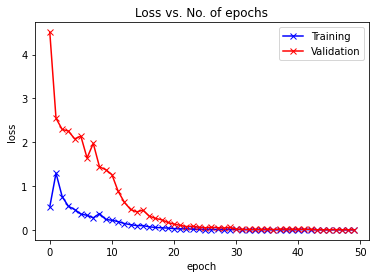

In [23]:
plot_losses()

In [46]:
# Testing the model
test_model = ResNet9()
PATH = './fold8.pth'
test_model = torch.load(PATH)
test_model.to(device)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [47]:
# Evaluating Test Data

preds, labels = evaluate(test_model, test_dataloader)

# Accuracy
accuracy = get_accuracy(preds, labels)
accuracy

tensor(0.6203, device='cuda:0')

In [ ]:
# F-1 SCORE

f1_score = get_f1score(preds, labels)
f1_score

In [ ]:
# Confusion Matrix

confusion_matrix = np.zeros((num_of_classes, num_of_classes))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = test_model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

matplot.figure(figsize=(12,7))

df_cm = pd.DataFrame((confusion_matrix/(np.sum(confusion_matrix, axis=1))), index=classes, columns=classes)
heatmap = sn.heatmap(df_cm, annot=True)